<div class="alert alert-info">

**Note:**
    
You can run this Notebook in Google Colab: https://colab.research.google.com/github/MiniXC/simple-back/blob/master/docs/intro/data_sources.ipynb

</div>

# Using External Data & Machine Learning
The tutorial so far only showed you how to build a strategy using price data, which in reality is nigh impossible to make profitable if you don't have the resources big players have. This tutorial will show you to use external data ([/r/worldnews headlines](https://www.kaggle.com/aaron7sun/stocknews) on kaggle) to predict the S&P500. This won't be a good strategy, but hopefully it will give you the tools to come up with one.

<div class="alert alert-warning">

**Warning:**
    
The following API is very likely to be reworked, and this tutorial is a work in progress.

</div>

In [1]:
%xmode Minimal

Exception reporting mode: Minimal


In [2]:
worldnews_url = "https://gist.githubusercontent.com/MiniXC/c39c633d5cd028365ba617e053114d1a/raw/e56ab9b1da6528e05fb4775daf829f2edf0d4087/worldnews.csv"

In [3]:
import pandas as pd

In [4]:
pd.read_csv(worldnews_url).head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


## DataProvider
We now have our news dataset. To help with caching and preventing time leaks, you can extend the `DataProvider` class and implement its `get` method.

In [5]:
from simple_back.data_providers import DataProvider

In [6]:
class WorldnewsProvider(DataProvider):
    def __init__(self, url, debug=True):
        super().__init__(debug=debug)
        if self.in_cache(url):
            self.df = self.get_cache(url)
        else:
            self.df = pd.read_csv(worldnews_url)
            self.df['Date'] = pd.to_datetime(self.df['Date'])
            self.df = self.df.set_index('Date').sort_index(ascending=False)
            self.set_cache(url, self.df)

    @property
    def name(self):
        return "Reddit /r/worldnews"
    
    def dates(self, symbol=None):
        return self.df.index
            
    def get(self, datetime, symbol):
        print(datetime, symbol)

<div class="alert alert-info">

**Note:**

Note that we set `debug` to `True`. This will disable caching while still allowing to implement it.
Caching can be very annoying when developing, so we recommend you only set this to `False` when your data provider is done.

</div>

In [7]:
news = WorldnewsProvider(worldnews_url)

There are two ways of accessing a providers data in a backtest. By calling the provider (`()`) and by getting a specific symbol from the provider (`[somesymbol]`). If we don't need the provider to fetch information with different names (e.g. sentiment for different stocks), we can just ignore `symbol`.

In [8]:
news['somesymbol']

2020-06-23 11:11:27.890553+00:00 somesymbol


In [9]:
news()

2020-06-23 11:11:27.890553+00:00 None


<div class="alert alert-info">

**Note:**

At the moment, our data provider is not part of a backtest, which is why its date is set to the current time. This enables you to use a data provider outside of backtests for real-time strategies.
    
</div>

Now we will get to the actual data: we always return all headlines from the closest day (back in time).

In [10]:
class WorldnewsProvider(DataProvider):
    def __init__(self, url, debug=True):
        super().__init__(debug=debug)
        if self.in_cache(url):
            self.df = self.get_cache(url)
        else:
            self.df = pd.read_csv(worldnews_url)
            self.df['Date'] = pd.to_datetime(self.df['Date'])
            self.df = self.df.set_index('Date').sort_index(ascending=False)
            self.set_cache(url, self.df)

    @property
    def name(self):
        return "Reddit /r/worldnews"
    
    def dates(self, symbol=None):
        return self.df.index
            
    def get(self, datetime, symbol):
        latest_date = None
        for date in self.dates():
            if date < datetime.date():
                latest_date = date
                break
        return self.df.loc[latest_date]

In [11]:
news = WorldnewsProvider(worldnews_url)

In [12]:
news().head()

,News
Date,
2016-07-01,A 117-year-old woman in Mexico City finally re...
2016-07-01,IMF chief backs Athens as permanent Olympic host
2016-07-01,"The president of France says if Brexit won, so..."
2016-07-01,British Man Who Must Give Police 24 Hours' Not...
2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [13]:
from datetime import datetime
# the backtester will later set current_datetime as follows
news.current_datetime = datetime(2009, 12, 20, 0, 0)
news().head()

,News
Date,
2009-12-19,b'Sarah Palin kicked out of hospital fundraise...
2009-12-19,"b""General Electric is using England's draconia..."
2009-12-19,"b""'A young woman walks into a bar, drinks too ..."
2009-12-19,b'Drug giant GE Healthcare uses UK libel law t...
2009-12-19,b'George Orwell put fish and chips first among...


## Target DataProvider
If we want to use this data to train a machine learning model, we will also need `target` values to predict. We can best do this by extending a `DailyDataProvider`. This type of provider is tied to events instead of times and is meant to provide a value on every trading day.

In [14]:
from simple_back.data_providers import DailyPriceProvider, YahooFinanceProvider
from dateutil.relativedelta import relativedelta

In [15]:
class TargetDataProvider(DailyPriceProvider):
    def __init__(self, wordlnews_url, debug=True):
        self.prices = YahooFinanceProvider(debug=debug)
        self.news = WorldnewsProvider(worldnews_url, debug=debug)
        super().__init__(debug=debug)
        
    @property
    def name(self):
        return "Target Price Change"
    
    def get(self, symbol, date, event):
        x = []
        y = []
        if isinstance(date, slice):
            start_date = date.start
            date = date.stop
            while date > self.news.dates().min() and (start_date is None or date > start_date):
                self.prices.set_date_event(date, event)
                try:
                    yesterday_df = self.prices[symbol].iloc[-1].copy()
                    if len(yesterday_df) > 0:
                        change = yesterday_df['close'] - yesterday_df['open']
                        if change > 0:
                            change = 'positive'
                        else:
                            change = 'negative'
                        x.append(self.news(datetime.combine(date, datetime.min.time())))
                        y.append(change)
                except ValueError:
                    pass
                date = date - relativedelta(days=1)
        else:
            self.prices.set_date_event(date, event)
            yesterday_df = self.prices[symbol].iloc[-1].copy()
            x = self.news(datetime.combine(date, datetime.min.time()))
            change = yesterday_df['close'] - yesterday_df['open']
            if change > 0:
                change = 'positive'
            else:
                change = 'negative'
            y = change
        return x, y

In [16]:
target = TargetDataProvider(worldnews_url)

In [17]:
from datetime import date

x, y = target['^GSPC', date(2014,12,28)]

In [18]:
x.head(), y

(                                                         News
 Date                                                         
 2014-12-27  Boy, 14, escapes ISIS by volunteering to suici...
 2014-12-27  Britain has surpassed France as the world's 5t...
 2014-12-27  N. Korea calls Obama 'monkey,' blames U.S. for...
 2014-12-27  "The DNA of every animal in world history will...
 2014-12-27            Sweden to scrap new election: confirmed,
 'positive')

Lets now get all data. We will have to set debug to false or every price will be downloaded repeatedly.

In [19]:
target = TargetDataProvider(worldnews_url, debug=False)
x, y = target['^GSPC']

In [20]:
x[0], y[0]

(                                                         News
 Date                                                         
 2016-07-01  A 117-year-old woman in Mexico City finally re...
 2016-07-01   IMF chief backs Athens as permanent Olympic host
 2016-07-01  The president of France says if Brexit won, so...
 2016-07-01  British Man Who Must Give Police 24 Hours' Not...
 2016-07-01  100+ Nobel laureates urge Greenpeace to stop o...
 2016-07-01  Brazil: Huge spike in number of police killing...
 2016-07-01  Austria's highest court annuls presidential el...
 2016-07-01  Facebook wins privacy case, can track any Belg...
 2016-07-01  Switzerland denies Muslim girls citizenship af...
 2016-07-01  China kills millions of innocent meditators fo...
 2016-07-01  France Cracks Down on Factory Farms - A viral ...
 2016-07-01  Abbas PLO Faction Calls Killer of 13-Year-Old ...
 2016-07-01  Taiwanese warship accidentally fires missile t...
 2016-07-01  Iran celebrates American Human Rights Week

We can now get a pair of the data we want to use for prediction and the target change for any given day. We will use this data to train a classifier. For ease of use, we will use TFIDF to convert the documents to vectors. We will train LightGBM to classify them.

In [21]:
%%capture
!pip install xgboost

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import lightgbm as lgb

In [23]:
def to_tfidf(x):
    x = [' '.join(day['News']) for day in x]
    return TfidfVectorizer().fit_transform(x)

In [24]:
x_tfidf = to_tfidf(x)

In [25]:
y_target = label_binarize(y, classes=['negative','positive']).flatten()

In [26]:
len(x), len(y)

(1367, 1367)

In [27]:
x_train, x_test =  x_tfidf[:1000],  x_tfidf[-367:]
y_train, y_test = y_target[:1000], y_target[-367:]

In [28]:
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# read in data
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
# specify parameters via map
param = {
    'max_depth':3,
    'eta':0.01,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'verbosity': 1,
    'subsample': .9,
}
num_round = 100
metrics = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evals=metrics, early_stopping_rounds=10)
# make prediction
preds = bst.predict(dtest)

[0]	train-error:0.38700	eval-error:0.50136
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 10 rounds.
[1]	train-error:0.37300	eval-error:0.46049
[2]	train-error:0.34400	eval-error:0.45504
[3]	train-error:0.32700	eval-error:0.47139
[4]	train-error:0.32700	eval-error:0.45777
[5]	train-error:0.31700	eval-error:0.44414
[6]	train-error:0.32200	eval-error:0.44959
[7]	train-error:0.32500	eval-error:0.45777
[8]	train-error:0.31300	eval-error:0.46866
[9]	train-error:0.31800	eval-error:0.45504
[10]	train-error:0.31400	eval-error:0.45777
[11]	train-error:0.31000	eval-error:0.46049
[12]	train-error:0.31100	eval-error:0.46321
[13]	train-error:0.30300	eval-error:0.45777
[14]	train-error:0.30500	eval-error:0.46321
[15]	train-error:0.29500	eval-error:0.46321
Stopping. Best iteration:
[5]	train-error:0.31700	eval-error:0.44414



In [30]:
f1_score(y_test, np.round(preds)), accuracy_score(y_test, np.round(preds))

(0.6780303030303031, 0.5367847411444142)

In [31]:
precision_score(y_test, np.round(preds)), recall_score(y_test, np.round(preds))

(0.549079754601227, 0.8861386138613861)

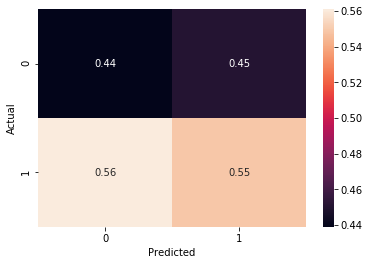

In [32]:
sns.heatmap(confusion_matrix(y_test, np.round(preds), normalize='pred'), annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual');

## Prediction Data Provider & Backtesting

We can see that the majority class, 'positive' occurs much more frequently (not too surprising with a market index) and is predicted correctly 54% of the time. Downside is only predicted correctly 40% of the time, which means our strategy should only use buy signals instead of sells ones.

In [33]:
class PredictionDataProvider(DailyPriceProvider):
    def __init__(self, wordlnews_url, debug=True):
        self.prices = YahooFinanceProvider(debug=debug)
        self.news = WorldnewsProvider(worldnews_url, debug=debug)
        super().__init__(debug=debug)
        
    @property
    def name(self):
        return "Predict Price Change"
    
    def train(self, x, y):
        total_len = x.shape[0]
        test_size = int(x.shape[0]*0.2)
        x_train, x_test = x[:total_len-test_size], x[-test_size:]
        y_train, y_test = y[:total_len-test_size], y[-test_size:]
        # read in data
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dtest = xgb.DMatrix(x_test, label=y_test)
        # specify parameters via map
        param = {
            'max_depth':3,
            'eta':0.01,
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'verbosity': 0,
            'subsample': .9,
        }
        num_round = 100
        metrics = [(dtrain, 'train'), (dtest, 'eval')]
        bst = xgb.train(param, dtrain, num_round, evals=metrics, early_stopping_rounds=10, verbose_eval=False)
        self.bst = bst
        
    def predict(self, x):
        return self.bst.predict(x)
    
    def get(self, symbol, date, event):
        x, y = [], []
        if isinstance(date, slice):
            start_date = date.start
            date = date.stop
            while date > self.news.dates().min() and (start_date is None or date > start_date):
                self.prices.set_date_event(date, event)
                try:
                    yesterday_df = self.prices[symbol].iloc[-1].copy()
                    if len(yesterday_df) > 0:
                        change = yesterday_df['close'] - yesterday_df['open']
                        if change > 0:
                            change = 'positive'
                        else:
                            change = 'negative'
                        x.append(self.news(datetime.combine(date, datetime.min.time())))
                        y.append(change)
                except ValueError:
                    pass
                date = date - relativedelta(days=1)
        else:
            raise ValueError()
        self.vec = TfidfVectorizer()
        x = self.vec.fit_transform([' '.join(day['News']) for day in x])
        y = label_binarize(y, classes=['negative','positive']).flatten()
        self.train(x, y)
        current_news = self.news(datetime.combine(date+relativedelta(days=1), datetime.min.time()))
        x = self.vec.transform([' '.join(current_news['News'])])
        return self.predict(xgb.DMatrix(x))

In [34]:
target = PredictionDataProvider(worldnews_url, debug=False)
target['^GSPC', :date(2015,1,1)]

array([0.5199328], dtype=float32)

In [35]:
from simple_back.backtester import BacktesterBuilder

builder = (
   BacktesterBuilder()
   .balance(10_000)
   .calendar('NYSE')
   .compare(['^GSPC']) # strategies to run
   .live_progress() # show a progress bar using tqdm
   .live_plot() # we assume we are running this in a Jupyter Notebook
   .data(target)
)

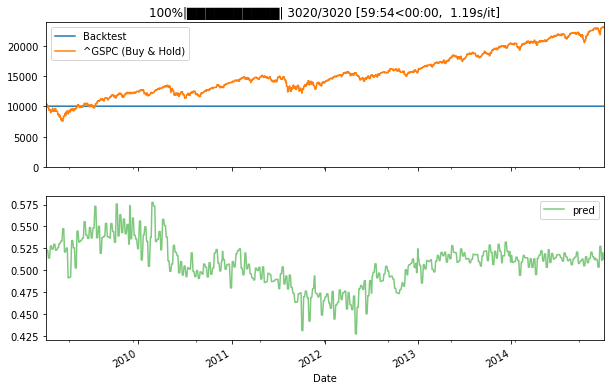

In [36]:
bt = builder.build()
for day, event, b in bt['2009-1-1':'2015-1-1']:
    pred = b.data['Predict Price Change']['^GSPC',:day][0]
    b.add_metric('pred', pred)

This backtest needs quite some time, but once it has completed, all our predictions are cached. This notebook is very poorly optimized, e.g. we are vectorizing training data anew each iteration.

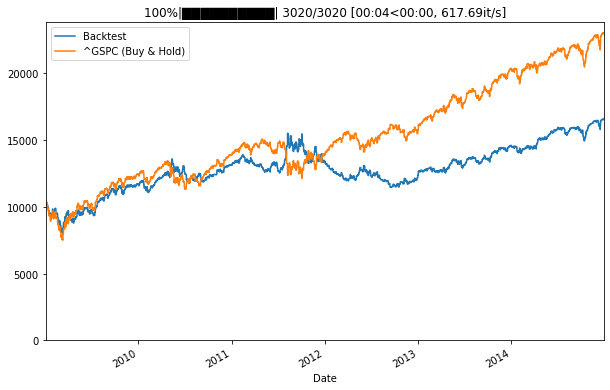

In [37]:
bt = builder.build()
for day, event, b in bt['2009-1-1':'2015-1-1']:
    pred = b.data['Predict Price Change']['^GSPC',:day][0]
    if event == 'open':
        if pred > .5:
            b.long('^GSPC', percent=1)
        if pred < .5:
            b.short('^GSPC', percent=1)
    if event == 'close':
        b.pf.liquidate()

Our backtest performs worse than the S&P500, but correctly predicts some drawdowns in the end of 2011.